# Emojify! 

Have you ever wanted to make your text messages more expressive? Your emojifier app will help you do that. 
So rather than writing:
>"Congratulations on the promotion! Let's get coffee and talk. Love you!"   

The emojifier can automatically turn this into:
>"Congratulations on the promotion! 👍 Let's get coffee and talk. ☕️ Love you! ❤️"

* You will implement a model which inputs a sentence (such as "Let's go see the baseball game tonight!") and finds the most appropriate emoji to be used with this sentence (⚾️).

In [1]:
import numpy as np
from emo_utils import *
import emoji
import matplotlib.pyplot as plt

%matplotlib inline

### Data Preprocessing

In [196]:
X_train, Y_train = read_csv('emojify_data.csv')
X_test, Y_test = read_csv('tesss.csv')

In [197]:
maxLen = len(max(X_train, key=len).split())

In [198]:
for idx in range(10):
    print(X_train[idx], label_to_emoji(Y_train[idx]))

French macaroon is so tasty 🍴
work is horrible 😞
I am upset 😞
throw the ball ⚾
Good joke 😄
what is your favorite baseball game ⚾
I cooked meat 🍴
stop messing around 😞
I want chinese food 🍴
Let us go play baseball ⚾


In [199]:
Y_oh_train = convert_to_one_hot(Y_train, C = 5)
Y_oh_test = convert_to_one_hot(Y_test, C = 5)

In [200]:
idx = 20
print("Sentence '{}' has label index {}, which is emoji {}".format(X_train[idx],Y_train[idx],label_to_emoji(Y_train[idx])))
print("Label index {} in one-hot encoding format is {}".format(Y_train[idx],Y_oh_train[idx]))

Sentence 'I am frustrated' has label index 3, which is emoji 😞
Label index 3 in one-hot encoding format is [0. 0. 0. 1. 0.]


In [201]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('glove.6B.50d.txt')

In [9]:
word = "cucumber"
idx = 289846
print("There are a total of " + str(len(word_to_index.keys())) + " words in the vocabulary")
print("the index of", word, "in the vocabulary is", word_to_index[word])
print("the", str(idx) + "th word in the vocabulary is", index_to_word[idx])

There are a total of 400000 words in the vocabulary
the index of cucumber in the vocabulary is 113317
the 289846th word in the vocabulary is potatos


### Emojify - Basic

Sentence -> list of words -> word vectors -> compute their average -> feed in a NN with one hidden layer

In [57]:
def sentence_to_avg(sentence, word_to_vec_map):
    """
    Converts a sentence (string) into a list of words (strings). Extracts the GloVe representation of each word
    and averages its value into a single vector encoding the meaning of the sentence.
    
    Arguments:
    sentence -- string, one training example from X
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    
    Returns:
    avg -- average vector encoding information about the sentence, numpy-array of shape (50,)
    """
    
    # Split sentence into list of lower case words
    words = sentence.lower().split()

    # Average the word vectors by looping over the words in the sentence
    total = 0
    for w in words:
        total += word_to_vec_map[w]
    avg = total / len(words)
    
    return avg

In [22]:
avg = sentence_to_avg("Morrocan couscous is my favorite dish", word_to_vec_map)
print("avg = \n", avg)
print("It's shape = ", avg.shape)

avg = 
 [-0.008005    0.56370833 -0.50427333  0.258865    0.55131103  0.03104983
 -0.21013718  0.16893933 -0.09590267  0.141784   -0.15708967  0.18525867
  0.6495785   0.38371117  0.21102167  0.11301667  0.02613967  0.26037767
  0.05820667 -0.01578167 -0.12078833 -0.02471267  0.4128455   0.5152061
  0.38756167 -0.898661   -0.535145    0.33501167  0.68806933 -0.2156265
  1.797155    0.10476933 -0.36775333  0.750785    0.10282583  0.348925
 -0.27262833  0.66768    -0.10706167 -0.283635    0.59580117  0.28747333
 -0.3366635   0.23393817  0.34349183  0.178405    0.1166155  -0.076433
  0.1445417   0.09808667]
It's shape =  (50,)


In [207]:
def model(X, Y, word_to_vec_map, learning_rate = 0.01, num_iterations = 400):
    """
    Model to train word vector representations in numpy.
    
    Arguments:
    X -- input data, numpy array of sentences as strings, of shape (m, 1)
    Y -- labels, numpy array of integers between 0 and 7, numpy-array of shape (m, 1)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    learning_rate -- learning_rate for the stochastic gradient descent algorithm
    num_iterations -- number of iterations
    
    Returns:
    pred -- vector of predictions, numpy-array of shape (m, 1)
    W -- weight matrix of the softmax layer, of shape (n_y, n_h)
    b -- bias of the softmax layer, of shape (n_y,)
    """
    
    np.random.seed(1)
    
    m = Y.shape[0]
    n_y = 6
    n_h = 50
    
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros(shape=(n_y, ))
    
    Y_oh = convert_to_one_hot(Y, C = n_y) 
    
    for t in range(num_iterations):
        for i in range(m):
            
            # Forward prop
            avg = sentence_to_avg(X[i], word_to_vec_map)
            z = np.dot(W, avg) + b
            a = softmax(z)
            
            # Compute Loss
            cost = - np.sum(np.multiply(Y_oh[i], np.log(a)))
            
            # Backprop
            dz = a - Y_oh[i]
            dW = np.dot(dz.reshape((n_y, 1)), avg.reshape(1, n_h))
            db = dz
            
            # Update the parameters
            W = W - learning_rate * dW
            b = b - learning_rate * db
            
        if t % 100 == 0:
            print("Epoch: " + str(t) + " --- cost = " + str(cost))
            pred = predict(X, Y, W, b, word_to_vec_map)

    return pred, W, b
            
    

In [208]:
print(X_train.shape)
print(Y_train.shape)
print(np.eye(5)[Y_train.reshape(-1)].shape)
print(X_train[0])
print(type(X_train))
Y = np.asarray([5,0,0,5, 4, 4, 4, 6, 6, 4, 1, 1, 5, 6, 6, 3, 6, 3, 4, 4])
print(Y.shape)

X = np.asarray(['I am going to the bar tonight', 'I love you', 'miss you my dear',
 'Lets go party and drinks','Congrats on the new job','Congratulations',
 'I am so happy for you', 'Why are you feeling bad', 'What is wrong with you',
 'You totally deserve this prize', 'Let us go play football',
 'Are you down for football this afternoon', 'Work hard play harder',
 'It is suprising how people can be dumb sometimes',
 'I am very disappointed','It is the best day in my life',
 'I think I will end up alone','My life is so boring','Good job',
 'Great so awesome'])

print(X.shape)
print(np.eye(5)[Y_train.reshape(-1)].shape)
print(type(X_train))


(183,)
(183,)
(183, 5)
French macaroon is so tasty
<class 'numpy.ndarray'>
(20,)
(20,)
(183, 5)
<class 'numpy.ndarray'>


In [209]:
pred, W, b = model(X_train, Y_train, word_to_vec_map)
print(pred)

Epoch: 0 --- cost = 1.2364712890128793
Accuracy: 0.34972677595628415
Epoch: 100 --- cost = 0.6553092778527012
Accuracy: 0.8579234972677595
Epoch: 200 --- cost = 0.49857195184550807
Accuracy: 0.9016393442622951
Epoch: 300 --- cost = 0.4107257294060037
Accuracy: 0.9180327868852459
[[4.]
 [3.]
 [3.]
 [1.]
 [2.]
 [1.]
 [4.]
 [3.]
 [4.]
 [1.]
 [3.]
 [3.]
 [2.]
 [2.]
 [4.]
 [3.]
 [3.]
 [2.]
 [3.]
 [1.]
 [3.]
 [2.]
 [2.]
 [2.]
 [0.]
 [1.]
 [0.]
 [4.]
 [2.]
 [0.]
 [2.]
 [2.]
 [0.]
 [3.]
 [4.]
 [0.]
 [2.]
 [1.]
 [3.]
 [1.]
 [2.]
 [4.]
 [0.]
 [3.]
 [0.]
 [4.]
 [2.]
 [3.]
 [4.]
 [2.]
 [2.]
 [3.]
 [0.]
 [2.]
 [2.]
 [3.]
 [2.]
 [3.]
 [2.]
 [2.]
 [3.]
 [3.]
 [0.]
 [2.]
 [3.]
 [3.]
 [2.]
 [0.]
 [0.]
 [2.]
 [3.]
 [2.]
 [4.]
 [1.]
 [3.]
 [3.]
 [0.]
 [2.]
 [3.]
 [2.]
 [0.]
 [3.]
 [3.]
 [2.]
 [2.]
 [4.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [3.]
 [0.]
 [4.]
 [3.]
 [1.]
 [2.]
 [3.]
 [3.]
 [2.]
 [3.]
 [0.]
 [3.]
 [0.]
 [2.]
 [0.]
 [3.]
 [3.]
 [4.]
 [3.]
 [1.]
 [3.]
 [4.]
 [3.]
 [2.]
 [3.]
 [3.]
 [3.]
 [1.]
 [4.]


In [210]:
print("Training set:")
pred_train = predict(X_train, Y_train, W, b, word_to_vec_map)
print('Test set:')
pred_test = predict(X_test, Y_test, W, b, word_to_vec_map)

Training set:
Accuracy: 0.9289617486338798
Test set:
Accuracy: 0.875


In [211]:
X_my_sentences = np.array(["i adore you", "i love you", "funny lol", "lets play with a ball", "food is ready", "not feeling happy"])
Y_my_labels = np.array([[0], [0], [2], [1], [4],[3]])

pred = predict(X_my_sentences, Y_my_labels , W, b, word_to_vec_map)
print_predictions(X_my_sentences, pred)

Accuracy: 0.6666666666666666

i adore you 😄
i love you ❤️
funny lol 😄
lets play with a ball ⚾
food is ready 🍴
not feeling happy 😄


(56,)
           ❤️    ⚾    😄    😞   🍴
Predicted  0.0  1.0  2.0  3.0  4.0  All
Actual                                 
0            6    0    1    0    0    7
1            0    8    0    0    0    8
2            4    0   14    0    0   18
3            0    0    1   15    0   16
4            0    0    0    1    6    7
All         10    8   16   16    6   56


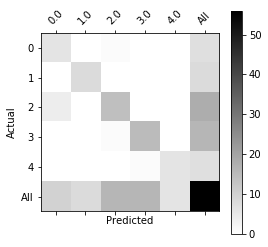

In [212]:
print(Y_test.shape)
print('           '+ label_to_emoji(0)+ '    ' + label_to_emoji(1) + '    ' +  label_to_emoji(2)+ '    ' + label_to_emoji(3)+'   ' + label_to_emoji(4))
print(pd.crosstab(Y_test, pred_test.reshape(56,), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred_test)

### Emojify - LSTM Model

Sentences -> List of words -> List of Indices -> Embeddings -> Embedding Matrix -> Embedding Layer ->
LSTM -> Dropout -> LSTM -> Dropout -> Softmax

In [219]:
import numpy as np
import keras
np.random.seed(42)

In [220]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]
    
    # Initialize X_indices as numpy zeros matrix of shape(no_of_examples, max_len_of_sentences)
    X_indices = np.zeros(shape=(m, max_len))
    
    for i in range(m):
        
        # Convert the ith training sentence in lower case and split is into words
        sentence_words = X[i].lower().split()
                
        # Loop over the words of sentence_words
        for j, word in enumerate(sentence_words):
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            X_indices[i, j] = word_to_index[word]
            
    return X_indices

In [221]:
X1 = np.array(["funny lol", "lets play baseball", "food is ready for you"])
X1_indices = sentences_to_indices(X1,word_to_index, max_len = 5)
print("X1 =", X1)
print("X1_indices =\n", X1_indices)

X1 = ['funny lol' 'lets play baseball' 'food is ready for you']
X1_indices =
 [[155345. 225122.      0.      0.      0.]
 [220930. 286375.  69714.      0.      0.]
 [151204. 192973. 302254. 151349. 394475.]]


In [222]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["the"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    # Step 1
    # Initialize the embedding matrix as a numpy array of zeros of shape(no_of_word_in_corpus, len_of_GloVe_vector)
    emb_matrix = np.zeros(shape=(vocab_len, emb_dim))
    
    # Step 2
    # Set each row "idx" of the embedding matrix to be 
    # the word vector representation of the idx'th word of the vocabulary
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]

    # Step 3
    # Define Keras non-trainable embedding layer
    embedding_layer = keras.layers.embeddings.Embedding(input_dim=vocab_len, output_dim=emb_dim, trainable=False)
    
    # Step 4
    # Build the embedding layer, it is required before setting the weights of the embedding layer. 
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [223]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("weights[0][1][3] =", embedding_layer.get_weights()[0][1][3])

weights[0][1][3] = -0.3403


In [281]:
def Emojify_V2(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """

    # Define the Input layer
    sentence_indices = keras.layers.Input(shape=input_shape, dtype='int32')
    
    # Create the embedding layer pretrained with GloVe Vectors
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer
    embeddings = embedding_layer(sentence_indices)
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden units. 
    # return_sequences is set to True in all LSTM layers except the last LSTM layer
    X = keras.layers.LSTM(units=128, return_sequences=True)(embeddings)
    # Add dropout with a probability of 0.5
    X = keras.layers.Dropout(rate=0.5)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden units
    X = keras.layers.LSTM(units=128, return_sequences=False)(X)
    # Add dropout with a probability of 0.5
    X = keras.layers.Dropout(rate=0.5)(X)
    # Propagate X through a Dense layer with 5 output units(n_classes) and softmax activation
    X = keras.layers.Dense(units=5)(X)
    # Softmax Activation layer
    X = keras.layers.Activation(activation='softmax')(X)
     
    # Create Model instance which converts sentence_indices into X.
    model = keras.models.Model(inputs=sentence_indices, outputs=X)
   
    return model

In [282]:
# Create a model instance

model = Emojify_V2((maxLen,), word_to_vec_map, word_to_index)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        (None, 10)                0         
_________________________________________________________________
embedding_32 (Embedding)     (None, 10, 50)            20000050  
_________________________________________________________________
lstm_57 (LSTM)               (None, 10, 128)           91648     
_________________________________________________________________
dropout_49 (Dropout)         (None, 10, 128)           0         
_________________________________________________________________
lstm_58 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_50 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 5)                 645       
__________

In [283]:
# Compile the model

model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])

In [284]:
# Get the data in correct format

X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
Y_train_oh = convert_to_one_hot(Y_train, C = 5)

In [285]:
# Run training

model.fit(X_train_indices, Y_train_oh, epochs = 50, batch_size = 32, shuffle=True)

Epoch 1/50
183/183 [==============================] - 11s 58ms/step - loss: 1.5595 - acc: 0.3497
Epoch 2/50
183/183 [==============================] - 1s 3ms/step - loss: 1.4342 - acc: 0.3661
Epoch 3/50
183/183 [==============================] - 1s 4ms/step - loss: 1.3161 - acc: 0.4754
Epoch 4/50
183/183 [==============================] - 1s 4ms/step - loss: 1.1314 - acc: 0.5301
Epoch 5/50
183/183 [==============================] - 1s 4ms/step - loss: 0.9550 - acc: 0.6175
Epoch 6/50
183/183 [==============================] - 1s 4ms/step - loss: 0.9035 - acc: 0.6667
Epoch 7/50
183/183 [==============================] - 1s 4ms/step - loss: 0.8317 - acc: 0.7158
Epoch 8/50
183/183 [==============================] - 1s 3ms/step - loss: 0.6686 - acc: 0.7486
Epoch 9/50
183/183 [==============================] - 1s 3ms/step - loss: 0.6160 - acc: 0.7432
Epoch 10/50
183/183 [==============================] - 1s 3ms/step - loss: 0.6831 - acc: 0.7268
Epoch 11/50
183/183 [==========================

In [286]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = maxLen)
Y_test_oh = convert_to_one_hot(Y_test, C = 5)
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
print()
print("Test accuracy = ", acc)

56/56 [==============================] - 3s 52ms/step

Test accuracy =  0.8571428571428571


In [287]:
# This code allows you to see the mislabelled examples
C = 5
y_test_oh = np.eye(C)[Y_test.reshape(-1)]
X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
pred = model.predict(X_test_indices)
for i in range(len(X_test)):
    x = X_test_indices
    num = np.argmax(pred[i])
    if(num != Y_test[i]):
        print('Expected emoji:'+ label_to_emoji(Y_test[i]) + ' prediction: '+ X_test[i] + label_to_emoji(num).strip())

Expected emoji:😄 prediction: he got a very nice raise	❤️
Expected emoji:😄 prediction: she got me a nice present	❤️
Expected emoji:😄 prediction: he is a good friend	❤️
Expected emoji:😄 prediction: We had such a lovely dinner tonight	❤️
Expected emoji:😄 prediction: valentine day is near	❤️
Expected emoji:😄 prediction: will you be my valentine	❤️
Expected emoji:❤️ prediction: I like your jacket 	😄
Expected emoji:🍴 prediction: I did not have breakfast 😞
